## Proje Hakkında

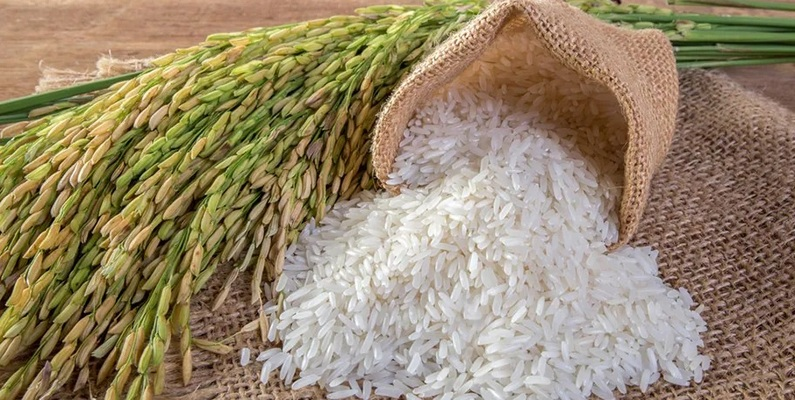


Bu notebook prinç çeşitlerini sınıflandırmak için bir görüntü sınıflandırıcı modeli oluşturmaktadır.

Veri seti: DATASET: https://www.muratkoklu.com/datasets/

Articles

Koklu, M., Cinar, I., & Taspinar, Y. S. (2021). Classification of rice varieties with deep learning methods. Computers and Electronics in Agriculture, 187, 106285. https://doi.org/10.1016/j.compag.2021.106285

## Kütüphanelerin Yüklenmesi

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print("tf versiyon:", tf.__version__)
import warnings
warnings.filterwarnings('ignore')

2024-05-05 09:41:51.544124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 09:41:51.544212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 09:41:51.678088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tf versiyon: 2.15.0


## Görüntü dosyaları içeriği 

In [3]:
#Create Data Frame from filepaths and labels
def create_dataset(folders,path):
    data = {'imgpath': [], 'labels': []}
    for folder in folders:
        folderpath = os.path.join(path, folder)
        files = os.listdir(folderpath)
        
        for file in files:
            filepath = os.path.join(folderpath, file)
            data['imgpath'].append(filepath)
            data['labels'].append(folder)

    dataset = pd.DataFrame(data)
    return dataset

In [4]:
path1 = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
folders1 = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'] 
df=create_dataset(folders1,path1)
df.head()

imgpath   labels
0  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Arborio
1  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Arborio
2  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Arborio
3  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Arborio
4  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Arborio

In [16]:
print('-- Veri seti bilgileri --\n')
print(f'Görsel Sayısı: {df.shape[0]}\n')
print(f'Etiket sayısı: {len(df.labels.unique())}\n')
print(f'Etiketler {df.labels.unique()}')

-- Veri seti bilgileri --

Görsel Sayısı: 75000

Etiket sayısı: 5

Etiketler ['Arborio' 'Basmati' 'Ipsala' 'Jasmine' 'Karacadag']


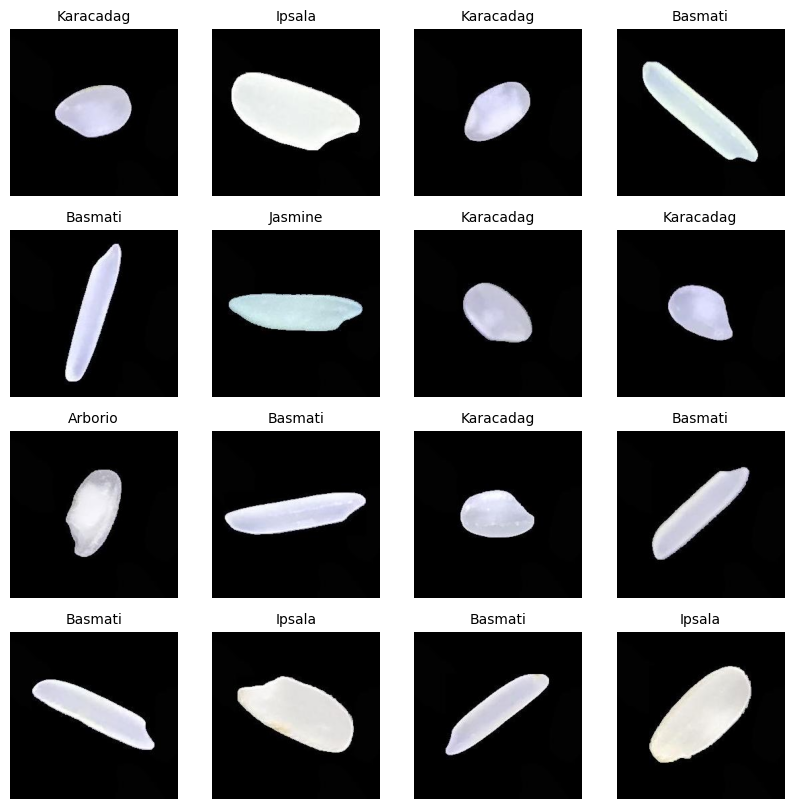

In [7]:
# Görselleştirme
import random
import matplotlib.gridspec as gridspec
from PIL import Image
rows = 4
cols = 4

selected_indices = random.sample(range(len(df)), rows * cols)

fig, axes = plt.subplots(rows, cols, figsize = (10, 10))
gs = gridspec.GridSpec(rows, cols, wspace = 0.0, hspace = 0.0)

for i, idx in enumerate(selected_indices):
    row = i // cols
    col = i % cols
    img_path = df['imgpath'].iloc[idx]
    label = df['labels'].iloc[idx]
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(label, fontsize = 10)

plt.show()

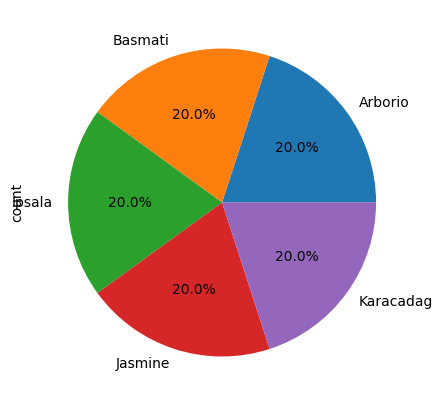

In [13]:
# pie plot label distribution
df.labels.value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(5,5));

In [25]:
#Split data train, val, test
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])
train_df.shape, val_df.shape, test_df.shape

((60000, 2), (7500, 2), (7500, 2))

In [29]:
%%time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed = 0
batch_size = 128
img_size = (224, 224)

generator = ImageDataGenerator(rescale = 1./255)

train_data = generator.flow_from_dataframe(train_df, x_col = 'imgpath', y_col = 'labels', 
                                           color_mode = 'rgb', class_mode = 'categorical', 
                                           batch_size = batch_size, target_size = img_size, 
                                           shuffle = True, seed = seed)

val_data = generator.flow_from_dataframe(val_df, x_col = 'imgpath', y_col = 'labels', 
                                         color_mode = 'rgb', class_mode = 'categorical', 
                                         batch_size = batch_size, target_size = img_size, 
                                         shuffle = False)

test_data = generator.flow_from_dataframe(test_df, x_col = 'imgpath', y_col = 'labels', 
                                          color_mode = 'rgb', class_mode = 'categorical', 
                                          batch_size = batch_size, target_size = img_size, 
                                          shuffle = False)

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
CPU times: user 1.37 s, sys: 1.8 s, total: 3.17 s
Wall time: 3min 42s


## Model Oluşturma

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy

model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))  # 5 kategori

# Modelin derlenmesi
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])#kategorik etiketler varsa loss = 'CategoricalCrossentropy()'

In [ ]:
model.summary()

In [38]:
%%time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')

history = model.fit(train_data, validation_data = val_data, 
                    epochs = 10, callbacks = [model_es, model_rlr])

Epoch 1/10


2024-05-05 10:16:17.032687: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[128,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-05 10:16:17.448390: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 7.24494, expected 6.29593
2024-05-05 10:16:17.448441: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.26025, expected 6.31124
2024-05-05 10:16:17.448451: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.9493, expected 6.00029
2024-05-05 10:16:17.448459: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference a

  1/469 ━━━━━━━━━━━━━━━━━━━━ 3:51:17 30s/step - accuracy: 0.3047 - loss: 1.6064

I0000 00:00:1714904195.556633     470 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/469 ━━━━━━━━━━━━━━━━━━━━ 28s 947ms/step - accuracy: 0.9057 - loss: 0.2855

2024-05-05 10:23:32.384057: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[96,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-05 10:23:32.724358: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 3.67231, expected 3.13495
2024-05-05 10:23:32.724417: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 831: 4.22376, expected 3.6864
2024-05-05 10:23:32.724441: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1221: 4.3116, expected 3.77424
2024-05-05 10:23:32.724456: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Differenc

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 0.9085 - loss: 0.2781

2024-05-05 10:25:03.935275: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 3.76966, expected 3.28511
2024-05-05 10:25:03.935342: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 3.51132, expected 3.02677
2024-05-05 10:25:03.935353: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 83: 3.5835, expected 3.09895
2024-05-05 10:25:03.935361: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180: 3.41391, expected 2.92936
2024-05-05 10:25:03.935369: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 197: 3.49656, expected 3.01202
2024-05-05 10:25:03.935378: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 198: 3.76377, expected 3.27923
2024-05-05 10:25:03.935386: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 229: 3.80452, expected 3.31997
2024-05-05 10:25:03.935394: E external/local_

469/469 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.9086 - loss: 0.2779 - val_accuracy: 0.9468 - val_loss: 1.0693 - learning_rate: 0.0010
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 149s 314ms/step - accuracy: 0.9665 - loss: 0.2443 - val_accuracy: 0.9684 - val_loss: 0.1743 - learning_rate: 0.0010
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 151s 317ms/step - accuracy: 0.9703 - loss: 0.1325 - val_accuracy: 0.9692 - val_loss: 0.0930 - learning_rate: 0.0010
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 153s 322ms/step - accuracy: 0.9770 - loss: 0.0681 - val_accuracy: 0.9811 - val_loss: 0.0599 - learning_rate: 0.0010
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 149s 314ms/step - accuracy: 0.9828 - loss: 0.0503 - val_accuracy: 0.9792 - val_loss: 0.0579 - learning_rate: 0.0010
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 151s 318ms/step - accuracy: 0.9848 - loss: 0.0414 - val_accuracy: 0.9737 - val_loss: 0.0798 - learning_rate: 0.0010
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 151s 318ms/step - accuracy: 0.9886 - l

## Modeli Değerlendir

In [39]:
test_results = model.evaluate(test_data, verbose = 0)

print(f'Test Loss: {test_results[0]:.5f}')
print(f'Test Accuracy: {(test_results[1] * 100):.2f}%')

Test Loss: 0.02582
Test Accuracy: 99.20%


In [40]:
#Modeli kaydet
model.save('/kaggle/working/rice_class_cnn.h5')

## Transfer Learning Modeli Oluştur

In [ ]:
# Başarı oranı çok yüksek olduğu için gerek duyulmadı.